In [240]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import statsmodels.api as sm
import requests
import io
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

### Raw data processing

In [241]:
#access data from github repo
url1 = "https://raw.githubusercontent.com/kirkhach/nfl-draft/main/data/predictor_data.csv"
download1 = requests.get(url1).content
url2 = "https://raw.githubusercontent.com/kirkhach/nfl-draft/main/data/outcome_data.csv"
download2 = requests.get(url2).content

#read in predictor data (ncaa, combine)
predictor2 = pd.read_csv(io.StringIO(download1.decode('utf-8')))

#limit data for 2000 (start of data) to 2016
predictor = predictor2[predictor2['year']<=2016]
# test 1
#read in outcome data (nfl)
outcome2 = pd.read_csv(io.StringIO(download2.decode('utf-8')))
outcome2 = outcome2.rename(columns={'Player':'player'})

#select career approximate value metric for each player
outcome3 = outcome2[['player','CarAV']]

#add approximate value metric for each player in predictor dataset
df = pd.merge(predictor,outcome3,on='player')
df = df.drop(columns=['url','missing_combine_vals','year'])
df.reset_index(inplace=True,drop=True)

In [242]:
#convert numerical predictors to numeric data types
X = ['year', 'height_inches','weight','forty','vertical','bench','broad','threecone','shuttle',
    'defense.ast.tackles','defense.fum.forced','defense.fum.rec','defense.fum.tds','defense.fum.yds',
    'defense.games','defense.int','defense.int.td','defense.int.yards','defense.loss.tackles','defense.pd',
    'defense.sacks','defense.seasons','defense.solo.tackes','defense.tackles','passing.attempts',
    'passing.comp.pct','passing.completions','passing.games','passing.pass.ints','passing.pass.tds',
    'passing.pass.yards','passing.seasons','receiving.games','receiving.rec.td','receiving.rec.yards',
    'receiving.receptions','receiving.rush.att','receiving.rush.td','receiving.rush.yds','receiving.scrim.plays',
    'receiving.scrim.tds','receiving.scrim.yds','receiving.seasons','rushing.games','rushing.rec.td',
    'rushing.rec.yards','rushing.receptions','rushing.rush.att','rushing.rush.td','rushing.rush.yds',
    'rushing.scrim.plays','rushing.scrim.tds','rushing.scrim.yds','rushing.seasons']

# for col in X:
#     X2 = pd.to_numeric(df[col],errors='coerce').fillna(0.0)
#     df[col]=X2
    
#change N/A team to undrafted
df['team']=df['team'].fillna("Undrafted")

#replace colleges with conferences
df['college'] = df['college'].replace(['North Carolina State','Florida State','Florida','Syracuse','Virginia Tech','Virginia','Notre Dame','Louisville','Georgia Tech','Pittsburgh','Clemson','North Carolina','Duke','Wake Forest','Miami (FL)'],'ACC')
df['college'] = df['college'].replace(['Oklahoma','Oklahoma State','Texas','Baylor','Texas Tech','Kansas State','Kansas','Iowa State','West Virginia','Missouri','TCU','Southern Methodist','Arkansas'],'Big 12')
df['college'] = df['college'].replace(['Iowa','Ohio State','Illinois','Iowa State','Penn State','Michigan State','Michigan','Nebraska','Wisconsin','Purdue','Rutgers','Maryland','Northwestern','Indiana','Minnesota'],'Big Ten')
df['college'] = df['college'].replace(['Colorado','Oregon','Southern California','California','UCLA','Arizona','Arizona State','Oregon State','Fresno State','Colorado State','Utah','UNLV','Stanford','Idaho','Utah State','Washington','Wyoming','San Diego','Washington State'],'Pac-12')
df['college'] = df['college'].replace(['Memphis','Cincinnati','Central Florida','Houston','Tulsa','Navy','Sourhtern Miss','South Florida','Tulane','Toledo','Akron','Marshall'],'American')
df['college'] = df['college'].replace(['South Carolina','Georgia','Alabama','Mississippi State','Tennessee','Ole Miss','Texas A&M','LSU','Mississippi','Auburn','Vanderbilt','Kentucky'],'SEC')


for college in df['college'].unique():
    if college not in ['SEC','ACC','Big Ten','Big 12','American','Pac-12']:
        df['college'] = df['college'].replace(college,'Other')


In [243]:
#full dataset: 1,428 unique players and 59 predictors (player name is not a predictor)
df

,pick,team,pos,player,college,height_inches,weight,forty,vertical,bench,...,rushing.rec.yards,rushing.receptions,rushing.rush.att,rushing.rush.td,rushing.rush.yds,rushing.scrim.plays,rushing.scrim.tds,rushing.scrim.yds,rushing.seasons,CarAV
0,67.0,JAX,OG,A.J. Cann,SEC,75,313,5.47,NaN,26.0,...,0,0,0,0,0,0,0,0,0,6.0
1,105.0,DET,CB,A.J. Davis,ACC,70,193,4.56,NaN,16.0,...,0,0,0,0,0,0,0,0,0,0.0
2,300.0,Undrafted,OLB,A.J. Edds,Big Ten,76,246,4.62,33.0,16.0,...,0,0,0,0,0,0,0,0,0,0.0
3,4.0,CIN,WR,A.J. Green,SEC,76,211,4.48,34.5,18.0,...,0,0,0,0,0,0,0,0,0,53.0
4,5.0,GNB,OLB,A.J. Hawk,Big Ten,73,248,4.59,40.0,24.0,...,0,0,0,0,0,0,0,0,0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,300.0,Undrafted,OG,Zane Beadles,Pac-12,76,310,5.28,NaN,27.0,...,0,0,0,0,0,0,0,0,0,42.0
3042,97.0,TEN,OLB,Zaviar Gooden,Big 12,73,234,4.47,34.0,27.0,...,0,0,0,0,0,0,0,0,0,3.0
3043,144.0,BUF,OT,Zebrie Sanders,ACC,78,320,5.33,27.0,28.0,...,0,0,0,0,0,0,0,0,0,0.0
3044,139.0,SDG,ILB,Zeke Moreno,Pac-12,74,248,4.76,NaN,24.0,...,0,0,0,0,0,0,0,0,0,10.0


In [244]:
print(df.columns.tolist())

['pick', 'team', 'pos', 'player', 'college', 'height_inches', 'weight', 'forty', 'vertical', 'bench', 'broad', 'threecone', 'shuttle', 'defense.ast.tackles', 'defense.fum.forced', 'defense.fum.rec', 'defense.fum.tds', 'defense.fum.yds', 'defense.games', 'defense.int', 'defense.int.td', 'defense.int.yards', 'defense.loss.tackles', 'defense.pd', 'defense.sacks', 'defense.seasons', 'defense.solo.tackes', 'defense.tackles', 'passing.attempts', 'passing.comp.pct', 'passing.completions', 'passing.games', 'passing.pass.ints', 'passing.pass.tds', 'passing.pass.yards', 'passing.seasons', 'receiving.games', 'receiving.rec.td', 'receiving.rec.yards', 'receiving.receptions', 'receiving.rush.att', 'receiving.rush.td', 'receiving.rush.yds', 'receiving.scrim.plays', 'receiving.scrim.tds', 'receiving.scrim.yds', 'receiving.seasons', 'rushing.games', 'rushing.rec.td', 'rushing.rec.yards', 'rushing.receptions', 'rushing.rush.att', 'rushing.rush.td', 'rushing.rush.yds', 'rushing.scrim.plays', 'rushing.sc

<AxesSubplot:>

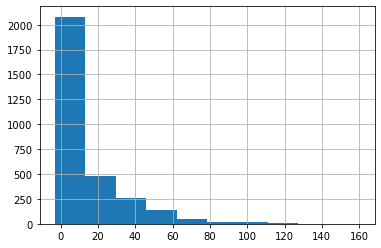

In [245]:
pd.Series(df['CarAV']).hist()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

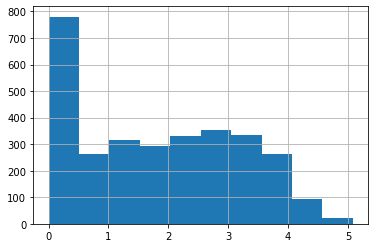

In [246]:
a2 = np.log1p(df['CarAV'])
pd.Series(a2).hist()

### Breaking Down by Position

Group into position groups: quarterback, running back/full back, wide reciever/tight end, offensive line, defensive line, linebacker, secondary

DB 614
DL 494
LB 414
OL 249
QB 184
RB 379
REC 712


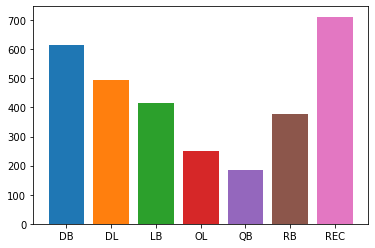

In [247]:
#group positions
df['pos'] = df['pos'].replace(['FB'],'RB')
df['pos'] = df['pos'].replace(['C','LS','OG','OT'],'OL')
df['pos'] = df['pos'].replace(['DE','DT'],'DL')
df['pos'] = df['pos'].replace(['CB','FS','SS'],'DB')
df['pos'] = df['pos'].replace(['WR','TE'],'REC')
df['pos'] = df['pos'].replace(['ILB','OLB'],'LB')


for pos,pos_df in df.groupby('pos'):
    print(pos,len(pos_df))
    plt.bar(pos,len(pos_df))

<AxesSubplot:xlabel='pos', ylabel='CarAV'>

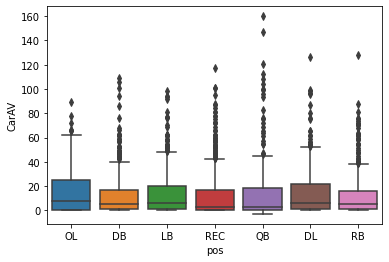

In [248]:
sns.boxplot(x="pos", y="CarAV", data=df)

In [249]:
#create df for each, missing combine values average
qb = df[(df['pos']=='QB')]
qb.reset_index(inplace=True,drop=True)
qb = qb.fillna(qb.mean())
qb = qb.drop(columns=['player','pos'])
for col in qb:
    if col not in ['team','college']:
        X2 = pd.to_numeric(df[col],errors='coerce').fillna(0.0)
        qb[col]=X2
qb = pd.get_dummies(qb)
qb.reset_index(inplace=True,drop=True)

rb = df[(df['pos']=='RB')]
rb.reset_index(inplace=True,drop=True)
rb = rb.fillna(rb.mean())
rb = rb.drop(columns=['player','pos'])

wr = df[(df['pos']=='REC')]
wr.reset_index(inplace=True,drop=True)
wr = wr.fillna(wr.mean())
wr = wr.drop(columns=['player','pos'])

ol = df[(df['pos']=='OL')]
ol.reset_index(inplace=True,drop=True)
ol = ol.fillna(ol.mean())
ol = ol.drop(columns=['player','pos'])

dl = df[(df['pos']=='DL')]
dl.reset_index(inplace=True,drop=True)
dl = dl.fillna(dl.mean())
dl = dl.drop(columns=['player','pos'])

lb = df[(df['pos']=='LB')]
lb.reset_index(inplace=True,drop=True)
lb = lb.fillna(lb.mean())
lb = lb.drop(columns=['player','pos'])

db = df[(df['pos']=='DB')]
db.reset_index(inplace=True,drop=True)
db = db.fillna(db.mean())
db = db.drop(columns=['player','pos'])

In [250]:
qb

,pick,height_inches,weight,forty,vertical,bench,broad,threecone,shuttle,defense.ast.tackles,...,team_TEN,team_Undrafted,team_WAS,college_ACC,college_American,college_Big 12,college_Big Ten,college_Other,college_Pac-12,college_SEC
0,67.0,75,313,5.47,0.0,26.0,0.0,0.00,0.00,0,...,0,0,0,0,0,0,0,0,0,1
1,105.0,70,193,4.56,0.0,16.0,0.0,0.00,0.00,17,...,0,0,0,0,0,0,0,0,0,1
2,300.0,76,246,4.62,33.0,16.0,117.0,7.19,4.28,149,...,0,0,0,0,0,0,0,0,1,0
3,4.0,76,211,4.48,34.5,18.0,126.0,6.91,4.21,0,...,0,0,0,0,0,0,0,0,1,0
4,5.0,73,248,4.59,40.0,24.0,115.0,6.82,3.96,52,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,125.0,73,232,4.76,0.0,0.0,0.0,0.00,0.00,155,...,0,0,0,1,0,0,0,0,0,0
180,107.0,71,207,4.40,35.5,16.0,123.0,6.84,4.16,0,...,1,0,0,0,0,1,0,0,0,0
181,175.0,75,321,5.23,27.0,21.0,100.0,8.00,4.69,0,...,0,0,0,0,0,0,0,1,0,0
182,62.0,70,191,4.49,0.0,0.0,0.0,0.00,0.00,0,...,0,1,0,0,0,1,0,0,0,0


### Pure Linear Regression

In [251]:
a = ['pick', 'height_inches', 'weight', 'forty', 'vertical', 'bench',
       'broad', 'threecone', 'shuttle']
linreg = linear_model.LinearRegression()



qbX = qb[a+[col for col in qb.columns if "passing" in col]]
ss = StandardScaler()
qbX = ss.fit_transform(qbX)
qbY = np.log1p(qb['CarAV'])
qbX_train, qbX_test, qbY_train, qbY_test = train_test_split(qbX, qbY, test_size=0.2, random_state=1)
qbmodel_final = linreg.fit(qbX_train,qbY_train)
qbfinal_predict = np.clip(qbmodel_final.predict(qbX_test),0, np.inf)
print('QB Coefficients: \n', qbmodel_final.coef_)
print('QB Mean squared error: %.2f'
      % mean_squared_error(qbY_test, qbfinal_predict))
print('QB R-squared: %.2f'
      % r2_score(qbY_test, qbfinal_predict))



#scores = cross_validate(linreg, X_train, Y_train, scoring=('r2', 'neg_mean_squared_error'), cv=10, return_train_score=True)







QB Coefficients: 
 [-0.67425624 -0.2221274   0.49412347 -0.2652898   0.26489725 -0.02823086
 -0.19053421 -0.03916416 -0.06221685  0.23855214  1.95281485  0.07689745
  1.10195964  0.31789751 -1.12026346  0.         -2.3256163 ]
QB Mean squared error: 1.55
QB R-squared: 0.16


### Regularized LinReg

In [252]:
ridge = Ridge(alpha=80)

qbmodel_final = ridge.fit(qbX_train,qbY_train)
qbfinal_predict = np.clip(qbmodel_final.predict(qbX_test),0, np.inf)
print('QB Coefficients: \n', qbmodel_final.coef_)
print('QB Mean squared error: %.2f'
      % mean_squared_error(qbY_test, qbfinal_predict))
print('QB R-squared: %.2f'
      % r2_score(qbY_test, qbfinal_predict))

QB Coefficients: 
 [-0.42653393 -0.00927861  0.0652705  -0.02956664  0.07966132  0.00059689
  0.01806705 -0.02000506 -0.05153873  0.12652126  0.01750738 -0.01217724
  0.02077096 -0.01700421 -0.05241933  0.          0.01654374]
QB Mean squared error: 1.49
QB R-squared: 0.19


In [253]:
lasso = Lasso(alpha=.1)

qbmodel_final = lasso.fit(qbX_train,qbY_train)
qbfinal_predict = np.clip(qbmodel_final.predict(qbX_test),0, np.inf)
print('QB Coefficients: \n', qbmodel_final.coef_)
print('QB Mean squared error: %.2f'
      % mean_squared_error(qbY_test, qbfinal_predict))
print('QB R-squared: %.2f'
      % r2_score(qbY_test, qbfinal_predict))

QB Coefficients: 
 [-0.58215442 -0.          0.         -0.          0.          0.
  0.          0.         -0.          0.07274015 -0.         -0.
 -0.         -0.         -0.          0.         -0.        ]
QB Mean squared error: 1.50
QB R-squared: 0.18


<AxesSubplot:>

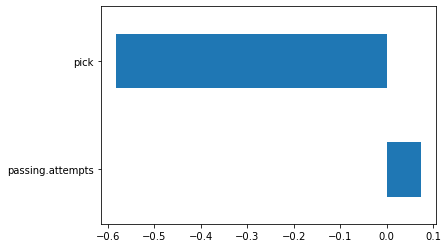

In [254]:
qbX = qb[a+[col for col in qb.columns if "passing" in col]]
co = pd.Series(qbmodel_final.coef_,index=qbX.columns)
co[abs(co)>0].sort_values(ascending=False).plot.barh()

In [257]:
# Classification 


#ave_carav = df["CarAV"].mean()  
#ave_carav
#std_carav = df["CarAV"].std()
#std_carav

#df["CarAV"].hist()
classification_df = df



        
   



classification_df.loc[classification_df.CarAV <= 5, 'Performace Classification'] = "Bad"
#classification_df.loc[classification_df.CarAV > 5 & classification_df.CarAV <= 10, 'Performace Classification'] = "Average"
#classification_df.loc[classification_df.CarAV > 10 & classification_df.CarAV <= 25, 'Performace Classification'] = "Good"
classification_df.loc[classification_df.CarAV > 25 , 'Performace Classification'] = "Excellent"
classification_df

,pick,team,pos,player,college,height_inches,weight,forty,vertical,bench,...,rushing.receptions,rushing.rush.att,rushing.rush.td,rushing.rush.yds,rushing.scrim.plays,rushing.scrim.tds,rushing.scrim.yds,rushing.seasons,CarAV,Performace Classification
0,67.0,JAX,OL,A.J. Cann,SEC,75,313,5.47,NaN,26.0,...,0,0,0,0,0,0,0,0,6.0,NaN
1,105.0,DET,DB,A.J. Davis,ACC,70,193,4.56,NaN,16.0,...,0,0,0,0,0,0,0,0,0.0,Bad
2,300.0,Undrafted,LB,A.J. Edds,Big Ten,76,246,4.62,33.0,16.0,...,0,0,0,0,0,0,0,0,0.0,Bad
3,4.0,CIN,REC,A.J. Green,SEC,76,211,4.48,34.5,18.0,...,0,0,0,0,0,0,0,0,53.0,Excellent
4,5.0,GNB,LB,A.J. Hawk,Big Ten,73,248,4.59,40.0,24.0,...,0,0,0,0,0,0,0,0,59.0,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,300.0,Undrafted,OL,Zane Beadles,Pac-12,76,310,5.28,NaN,27.0,...,0,0,0,0,0,0,0,0,42.0,Excellent
3042,97.0,TEN,LB,Zaviar Gooden,Big 12,73,234,4.47,34.0,27.0,...,0,0,0,0,0,0,0,0,3.0,Bad
3043,144.0,BUF,OL,Zebrie Sanders,ACC,78,320,5.33,27.0,28.0,...,0,0,0,0,0,0,0,0,0.0,Bad
3044,139.0,SDG,LB,Zeke Moreno,Pac-12,74,248,4.76,NaN,24.0,...,0,0,0,0,0,0,0,0,10.0,NaN


In [256]:
df

,pick,team,pos,player,college,height_inches,weight,forty,vertical,bench,...,rushing.receptions,rushing.rush.att,rushing.rush.td,rushing.rush.yds,rushing.scrim.plays,rushing.scrim.tds,rushing.scrim.yds,rushing.seasons,CarAV,Performace Classification
0,67.0,JAX,OL,A.J. Cann,SEC,75,313,5.47,NaN,26.0,...,0,0,0,0,0,0,0,0,6.0,NaN
1,105.0,DET,DB,A.J. Davis,ACC,70,193,4.56,NaN,16.0,...,0,0,0,0,0,0,0,0,0.0,Bad
2,300.0,Undrafted,LB,A.J. Edds,Big Ten,76,246,4.62,33.0,16.0,...,0,0,0,0,0,0,0,0,0.0,Bad
3,4.0,CIN,REC,A.J. Green,SEC,76,211,4.48,34.5,18.0,...,0,0,0,0,0,0,0,0,53.0,NaN
4,5.0,GNB,LB,A.J. Hawk,Big Ten,73,248,4.59,40.0,24.0,...,0,0,0,0,0,0,0,0,59.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3041,300.0,Undrafted,OL,Zane Beadles,Pac-12,76,310,5.28,NaN,27.0,...,0,0,0,0,0,0,0,0,42.0,NaN
3042,97.0,TEN,LB,Zaviar Gooden,Big 12,73,234,4.47,34.0,27.0,...,0,0,0,0,0,0,0,0,3.0,Bad
3043,144.0,BUF,OL,Zebrie Sanders,ACC,78,320,5.33,27.0,28.0,...,0,0,0,0,0,0,0,0,0.0,Bad
3044,139.0,SDG,LB,Zeke Moreno,Pac-12,74,248,4.76,NaN,24.0,...,0,0,0,0,0,0,0,0,10.0,NaN
